In [170]:
from typing import (
    List,
    Tuple,
    Dict,
    Optional,
)

import os
import sys
import csv

import altair as alt
import pandas as pd

EXPERIMENT_DIR = 'data/cached'

In [171]:
METRICS = {
    'al/valid/f1-measure-overall': 'Span F1',
    'al/valid/precision-measure-overall': 'Span Precision',
    'al/valid/recall-measure-overall': 'Span Recall',
    'al/valid/tag_f1': 'Token F1',
    'al/valid/tag_precision': 'Token Precision',
    'al/valid/tag_recall': 'Token Recall',
}

DataDef = List[
    Dict[str, object]
]

def parse_file(
    file_name: str,
    experiment_tag: str,
    weak_weight: float,
    weak_function: str,
    weak_train_method: str,
    trial: int,
) -> DataDef:
    output = []
    with open(file_name, 'r') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            
            # tag, value, step
            metric_name, metric_val, step = row
            if metric_name not in METRICS:
                continue
            output.append({
                'metric_name': METRICS[metric_name],
                'metric_val': round(float(metric_val), 2),
                'step': float(step),
                'tag': experiment_tag,
                'weak_function': weak_function,
                'weak_weight': weak_weight,
                'trial': trial,
                'weak_train_method': weak_train_method,
            })
    return output

def get_experiment_data(root_dir: str) -> DataDef:
    res = []
    for weak_train in os.listdir(root_dir):
        no_weak = weak_train == 'no_weak'
        weak_train_dir = os.path.join(
            root_dir,
            weak_train,
        )
        
        if no_weak:
            for trial_dir in os.listdir(weak_train_dir):
                if not trial_dir.startswith('trial_'):
                    print(f'skipping: {trial_dir}')
                    continue
                trial_num = int(trial_dir[len('trial_'):])
                summary_file = os.path.join(
                    weak_train_dir,
                    trial_dir,
                    'summary.csv',
                )

                parsed_data = parse_file(
                    file_name=summary_file,
                    experiment_tag='ADR',
                    weak_weight=0.01,
                    weak_function='no_weak',
                    weak_train_method='fine_tune',
                    trial=trial_num,
                )

                res.extend(parsed_data)
                
                parsed_data = parse_file(
                    file_name=summary_file,
                    experiment_tag='ADR',
                    weak_weight=0.01,
                    weak_function='no_weak',
                    weak_train_method='weighted',
                    trial=trial_num,
                )

                res.extend(parsed_data)
            continue
        for weak_weight in os.listdir(weak_train_dir):
            weak_weight = float(weak_weight)
            weight_dir = os.path.join(
                weak_train_dir,
                f'{weak_weight}',
            )
            for weak_function in os.listdir(weight_dir):
                weak_function_dir = os.path.join(
                    weight_dir,
                    weak_function,
                )

                for trial_dir in os.listdir(weak_function_dir):
                    if not trial_dir.startswith('trial_'):
                        print(f'skipping: {trial_dir}')
                        continue
                    trial_num = int(trial_dir[len('trial_'):])
                    summary_file = os.path.join(
                        weak_function_dir,
                        trial_dir,
                        'summary.csv',
                    )

                    parsed_data = parse_file(
                        file_name=summary_file,
                        experiment_tag='ADR',
                        weak_weight=weak_weight,
                        weak_function=weak_function,
                        weak_train_method=weak_train,
                        trial=trial_num,
                    )

                    res.extend(parsed_data)
    return res

data = get_experiment_data(EXPERIMENT_DIR)
data_frame = pd.DataFrame(data)
data_frame.head(2)

,metric_name,metric_val,step,tag,trial,weak_function,weak_train_method,weak_weight
0,Token F1,0.62,10.0,ADR,2,knn,fine_tune,0.01
1,Token F1,0.73,50.0,ADR,2,knn,fine_tune,0.01


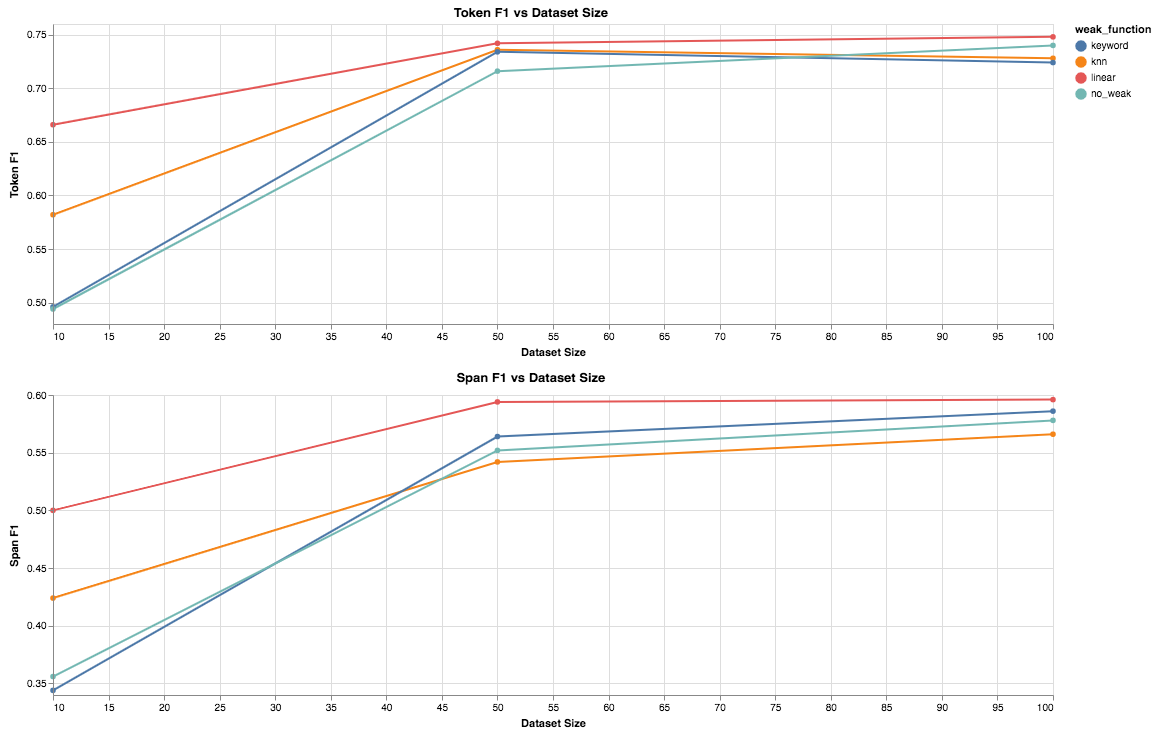

In [194]:
WEAK_WEIGHT = 0.01
WEAK_TRAIN_METHOD = 'fine_tune'

def metric_graph(data_frame: pd.DataFrame, metric: str, train_method: str) -> alt.Chart:
    def filter_graph(chart: alt.Chart) -> alt.Chart:
        return chart.transform_filter(
            alt.datum.metric_name == metric
        ).transform_filter(
            alt.datum.weak_weight == WEAK_WEIGHT
        ).transform_filter(
            alt.datum.weak_train_method == train_method,
        )
#     .transform_filter(
#             alt.datum.weak_function != 'knn'
#         ).transform_filter(
#             alt.datum.weak_function != 'keyword'
#         )

    base = alt.Chart(data_frame, title=f'{metric} vs Dataset Size')
    line = filter_graph(base.mark_line(point=True).encode(
        x=alt.X('step', title='Dataset Size'),
        y=alt.Y('mean(metric_val)', title=metric, scale=alt.Scale(zero=False)),
        color='weak_function:N',
    ))
    
    confidence_interval = filter_graph(base.mark_area(opacity=0.3).encode(
        x=alt.X('step'),
        y=alt.Y('ci0(metric_val):Q'),
        y2='ci1(metric_val):Q',
        color='weak_function:N',
    ))

    return (line).properties(width=1000)
metric_graph(data_frame, 'Token F1', 'fine_tune') & metric_graph(data_frame, 'Span F1', 'fine_tune')

In [107]:
temp = {'no_weak': [], 'keyword': []}
metric = 'Span F1'
step = 10
for entry in data:
    if entry['metric_name'] != metric:
        continue
    if entry['step'] != step:
        continue
    if entry['weak_train_method'] != 'weighted':
        continue
    if entry['weak_function'] == 'no_weak':
        temp['no_weak'].append(entry['metric_val'])
    if entry['weak_function'] == 'keyword':
        temp['keyword'].append(entry['metric_val'])
for key, val in temp.items():
    print(f'{key}: {sum(val) / len(val)}')

no_weak: 0.29800000000000004
keyword: 0.29800000000000004


In [108]:
temp

{'no_weak': [0.5, 0.24, 0.28, 0.11, 0.36],
 'keyword': [0.5, 0.24, 0.28, 0.11, 0.36]}